In [78]:
import numpy as np
import matplotlib.pyplot as plt

In [79]:
def initialize_membership_matrix(num_samples, num_clusters):
    membership_mat = np.random.rand(num_clusters, num_samples)
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

def initial_centroids(num_clusters, num_features):
    return np.random.rand(num_clusters, num_features)
    

In [80]:
def epsilon_insensitive_loss(y_true, y_pred, epsilon):
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)
    # Apply epsilon-insensitive penalty
    loss = np.maximum(0, errors - epsilon)
    return np.mean(loss)

In [81]:
def update_membership_matrix(data, centroids, num_clusters, epsilon, m):
    # Update the membership matrix
    num_samples = data.shape[0]
    membership_mat = np.zeros((num_clusters, num_samples)).astype('float128')
    for i in range(num_samples):
        denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m))) 
        for k in range(num_clusters):
            membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
            if np.isinf(membership_mat[k, i]):
                membership_mat[k, i] = 1
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

In [82]:
from scipy.optimize import minimize


EPSILON = .01
DATA = None
L    = None


def objective(x):
    global EPSILON 
    global DATA
    global L
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    temp = 0
    for k in range(len(a)):
        temp += (a[k] - b[k])*DATA[k,L]
    return temp + sum(a + b) * EPSILON

def constraint(x):
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    return sum(a) - sum(b)

def Lambda(num_samples, membership_mat, i_index, m):
    initial_guess = [0.] * num_samples*2
    bounds_a = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds_b = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds = np.concatenate((bounds_a, bounds_b))
    constraint_eq = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraint_eq)

    return result.x[:len(result.x)//2], result.x[len(result.x)//2:]

def update_centroid(data, num_samples, num_features, num_clusters, centroids, epsilon, membership_mat, m):
    global EPSILON, DATA, L
    EPSILON = epsilon
    DATA = data
    for i in range(num_clusters):
        for j in range(num_features):
            L = j
            l1, l2 = Lambda(num_samples, membership_mat, i, m)
            f, s = 0., 0.
            for ns in range(num_samples):
                if 0<l1[ns]<membership_mat[i, ns]:
                    f += data[ns][j] + epsilon
                if 0<l2[ns]<membership_mat[i, ns]:
                    s += data[ns][j] - epsilon
            # print(f, end=":")
            # print(s)
            centroids[i][j] = 1.1*(f+s) / np.unique(np.concatenate((l1, l2))).shape[0]
    
    return centroids
        

In [83]:
def fuzzy_cmeans(data, num_clusters, max_iter, epsilon, m):
    num_samples, num_features = data.shape
    cen_mat = initial_centroids(num_clusters, num_features)
    for _ in range(max_iter):
        print(_, end=',')
        mem_mat = update_membership_matrix(data, cen_mat, num_clusters, epsilon, m)
        cen_mat = update_centroid(data, num_samples, num_features, num_clusters, cen_mat, epsilon, mem_mat, m)
        
    print(cen_mat)
    print(mem_mat)
    return cen_mat, mem_mat
        

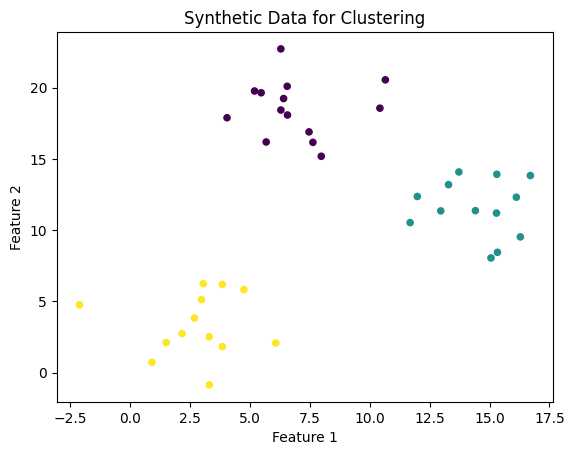

0,

/tmp/ipykernel_13046/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_13046/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_13046/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,[[ 8.7971003  12.28193646]
 [ 8.7971003  12.28193646]
 [ 8.80992751 12.29611444]]
[[0.3330011  0.33398648 0.33444233 0.33297163 0.33396608 0.33355901
  0.33523327 0.33301118 0.33484542 0.33378435 0.33275642 0.33364268
  0.333718   0.33368292 0.33300627 0.33270784 0.33364172 0.3335931
  0.33422954 0.3328179  0.3328206  0.33375613 0.33413789 0.33357056
  0.33291063 0.33419559 0.33291522 0.33301335 0.33399216 0.3329934
  0.33383658 0.33404872 0.33299747 0.33361768 0.33266706 0.3322214
  0.33288666 0.33293811 0.33363038 0.3336529 ]
 [0.3330011  0.33398648 0.33444233 0.33297163 0.33396608 0.33355901
  0.33523327 0.33301118 0.33484542 0.33378435 0.33275642 0.33364268
  0.333718   0.33368292 0.33300627 0.33270784 0.33364172 0.3335931
  0.33422954 0.3328179  0.3328206  0.33375613 0.33413789 0.33357056
  0.33291063 0.33419559 0.33291522 0.33301335 0.33399216 

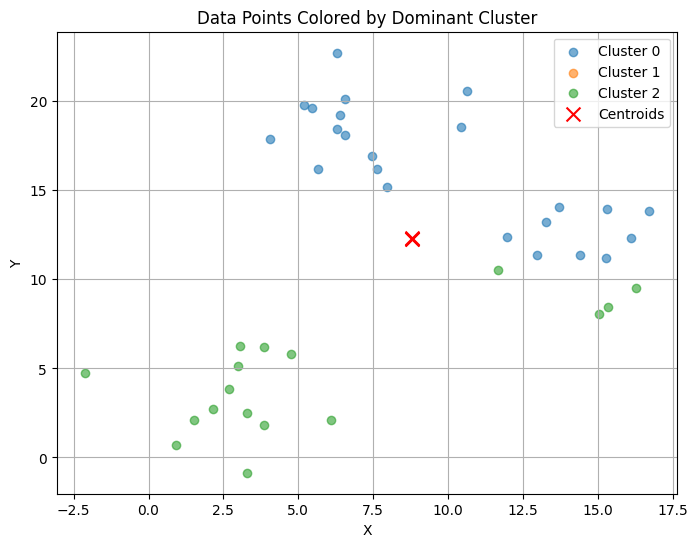

Normalized Mutual Information (NMI): 0.5407780067798014


In [88]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score



num_clusters=3
num_samples = 40

# Generate synthetic data with clusters
X, y = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=2, random_state=42)
X += 10



# Visualize the generated data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
plt.title('Synthetic Data for Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


centroids ,membership_mat = fuzzy_cmeans(data=X, num_clusters=num_clusters, max_iter=50, epsilon=1, m=2)

max_membership_cluster = np.argmax(membership_mat, axis=0)
# Plot data points with colors based on their corresponding centroids
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X[max_membership_cluster == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Data Points Colored by Dominant Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()
# Assuming 'y' contains the true cluster labels and 'max_membership_cluster' contains the cluster labels assigned by your fuzzy clustering algorithm
nmi = normalized_mutual_info_score(y, max_membership_cluster)
print("Normalized Mutual Information (NMI):", nmi)